# Model Performance


In [3]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from random import randint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
from joblib import parallel_backend
from xgboost import XGBRegressor


In [4]:
df = pd.read_csv('synthetic_data.csv')

In [5]:
new_columns = ['TemP (K)', 'PS (mm)', 'BET (m2/g)', 'PV (cm3)', 'C (wt.%)', 'H  (wt.%)', 'N  (wt.%)', 'O  (wt.%)', 'TP_Ciprofloxacin', 'TP_Tetracycline', 'TP_Tetracycline']
X = df.drop(['Qm (mg/g)', 'C (wt.%)', 'H  (wt.%)', 'PS (mm)'], axis =1)  # Features
y = df['Qm (mg/g)']  # Target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']


## Random Forest Regressor(GridSearchCV)

In [8]:
# Define the parameter grid to search through
rf_regressor = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [15, 25, 50, 100, 150],
    'max_depth': [None, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with cross-validation on the training set
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring=scoring, refit="neg_mean_squared_error", cv=5, verbose=1, n_jobs=-1, return_train_score=False)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Extract cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)

# # Extract R-squared and MAE from cross-validation results
# cv_results['mean_test_r2'] = cv_results['mean_test_score']
# cv_results['mean_test_mae'] = -cv_results['mean_test_score']  # MAE is positive, so negate back

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [9]:
rf_r2 = cv_results[f'mean_test_r2'] *-1
mean_rf_r2 = rf_r2.mean()
rf_mae = cv_results[f'mean_test_neg_mean_absolute_error'] * -1
mean_rf_mae = rf_mae.mean()
rf_rmse = np.sqrt(cv_results[f'mean_test_neg_mean_squared_error'] * -1)
mean_rf_rmse = rf_rmse.mean()

In [10]:
k_folds = KFold(n_splits = 5)
rf_mae = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
rf_r2 = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
rf_rmse = np.sqrt(cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [11]:
best_params_rf = grid_search.best_params_

In [12]:
#untuned cross validation
default_rf = RandomForestRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "r2")

In [13]:
untuned_r2_result

array([0.04561983, 0.02314171, 0.04039418, 0.01379276, 0.07062787])

In [14]:
average_untuned_mae_rf = np.mean(untuned_mae_result) *-1
average_untuned_rmse_rf = np.mean(np.sqrt(untuned_rmse_result*-1))
average_untuned_r2_rf = np.mean(untuned_r2_result)


In [15]:
rf_results = {
    "Tunned": {"r2": rf_r2, "rmse": rf_rmse, "mae": rf_mae},
    "Untunned": {"r2": untuned_r2_result, "rmse": np.sqrt(untuned_rmse_result*-1), "mae": untuned_mae_result *-1}
}

In [16]:
rf_results

{'Tunned': {'r2': array([0.08419462, 0.04787442, 0.06787877, 0.05324719, 0.08192403]),
  'rmse': array([26.3767415 , 26.05359897, 26.22547853, 26.49519856, 26.14862154]),
  'mae': array([22.82389377, 22.45884579, 22.58295583, 22.70065342, 22.4351987 ])},
 'Untunned': {'r2': array([0.04561983, 0.02314171, 0.04039418, 0.01379276, 0.07062787]),
  'rmse': array([26.92652139, 26.38981774, 26.60931264, 27.04163656, 26.30899826]),
  'mae': array([23.17481354, 22.4673364 , 22.72243676, 23.08597335, 22.41396023])}}

In [17]:
def visualize(dataframe, model):
    records = []
    for category, metrics in dataframe.items():
        for metric, values in metrics.items():
            for value in values:
                records.append([category, metric, value])

    df = pd.DataFrame(records, columns=['Category', 'Metric', 'Value'])
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    # Define y-limits for each metric
    y_limits = {
        'r2': (0, 0.2),
        'rmse': (25, 28),
        'mae': (20, 25)
    }

    # Plot each metric in a separate subplot
    for ax, metric in zip(axes, y_limits.keys()):
        sns.boxplot(x='Category', y='Value', data=df[df['Metric'] == metric], ax=ax)
        ax.set_ylim(y_limits[metric])
        ax.set_title(f'{model} Boxplot of {metric.upper()}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Value')


    # Adjust layout
    plt.tight_layout()
    plt.show()


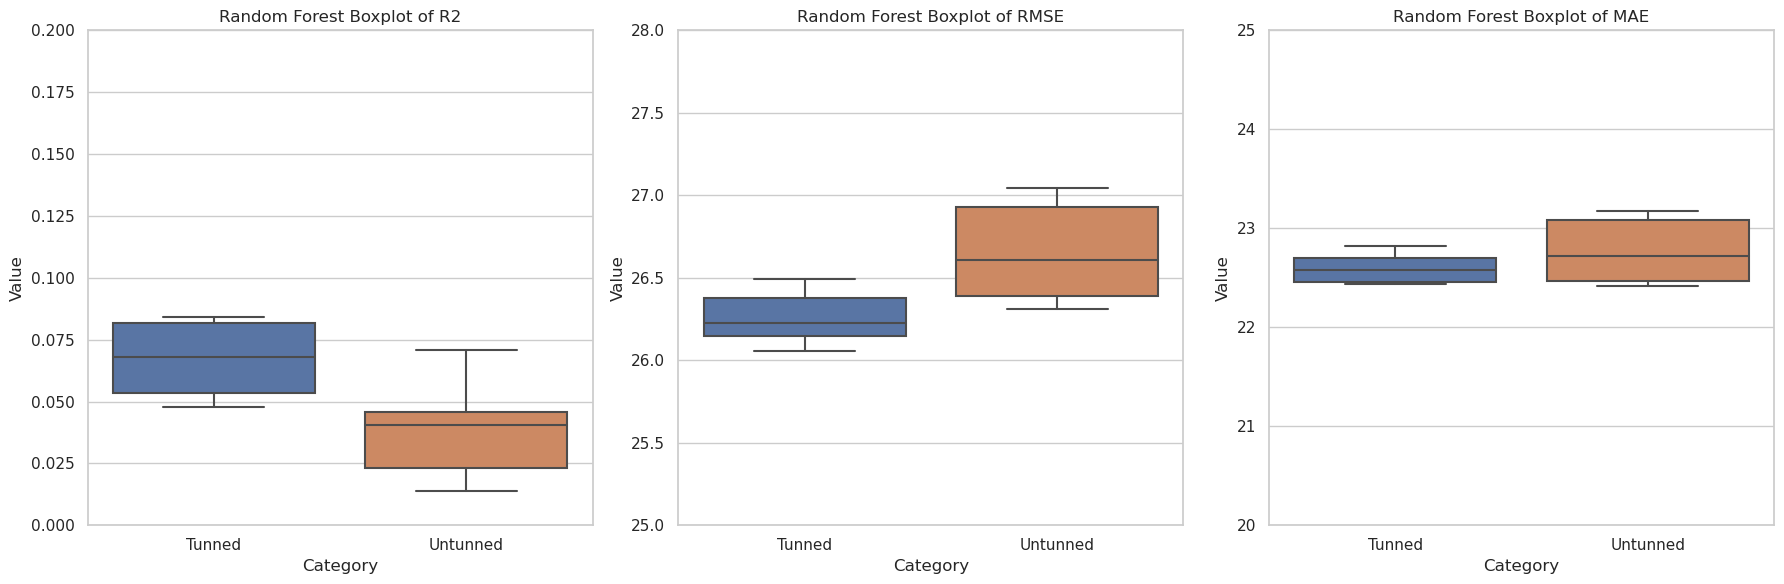

In [18]:
visualize(rf_results, "Random Forest")

### Decision Tree


In [19]:
def get_rmse_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
    results = {
        'Decision Tree': np.sqrt(dt_scores * -1),
        }
    results = pd.DataFrame(results)
    return results

def get_r2_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "r2")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

def get_mae_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

In [20]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': [None, 'auto', 'sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1))
}

dt_model = RandomizedSearchCV(DecisionTreeRegressor()
    ,param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,       # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  )
search_dt = dt_model.fit(X_train, y_train)
search_dt.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'splitter': 'random',
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_features': 0.7000000000000001,
 'max_depth': 4,
 'criterion': 'poisson'}

In [21]:
best_params_dt = search_dt.best_params_

In [22]:
dt = DecisionTreeRegressor()
dt.set_params(**search_dt.best_params_)

DecisionTreeRegressor(criterion='poisson', max_depth=4,
                      max_features=0.7000000000000001, min_samples_leaf=9,
                      min_samples_split=6, splitter='random')

In [23]:
r2_results = get_r2_errors_cv(X, y, dt, "r2", split=5)
print(r2_results)

   Decision Tree
0      -0.044856
1       0.002458
2      -0.038444
3      -0.021571
4      -0.044731


In [24]:
r2_results

,Decision Tree
0,-0.044856
1,0.002458
2,-0.038444
3,-0.021571
4,-0.044731


In [25]:
average_r2_dt = np.mean(r2_results.values.flatten())
average_r2_dt

-0.0294289188758859

In [26]:
mae_results = get_mae_errors_cv(X, y, dt, "neg_mean_absolute_error")
print(mae_results)

   Decision Tree
0      23.860701
1      22.962189
2      23.360098
3      23.353018
4      22.830951


In [27]:
average_mae_dt = np.mean(mae_results.values.flatten())
average_mae_dt

23.273391324308463

In [28]:
rmse_results = get_rmse_errors_cv(X, y, dt, "neg_mean_squared_error", split=5)
print(rmse_results)

   Decision Tree
0      26.889063
1      26.675119
2      26.618573
3      26.649842
4      26.455416


In [29]:
average_rmse_dt = np.mean(rmse_results.values.flatten())
average_rmse_dt

26.657602765566686

In [30]:
#untuned decision tree
default_dt = DecisionTreeRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "r2")



In [31]:
average_untuned_mae_dt = np.mean(untuned_mae_result_dt) *-1
average_untuned_rmse_dt = np.mean(np.sqrt(untuned_rmse_result_dt*-1))
average_untuned_r2_dt = np.mean(untuned_r2_result_dt)


In [32]:
dt_results = {
    "Tunned": {"r2": r2_results.to_numpy().flatten(), "rmse": rmse_results.to_numpy().flatten(), "mae": mae_results.to_numpy().flatten()},
    "Untunned": {"r2": untuned_r2_result_dt, "rmse": np.sqrt(untuned_rmse_result_dt*-1), "mae": untuned_mae_result_dt *-1}
}


In [33]:
dt_results

{'Tunned': {'r2': array([-0.04485562,  0.00245784, -0.03844393, -0.02157139, -0.04473149]),
  'rmse': array([26.88906337, 26.67511868, 26.61857349, 26.64984205, 26.45541623]),
  'mae': array([23.86070106, 22.96218869, 23.36009757, 23.35301847, 22.83095084])},
 'Untunned': {'r2': array([-0.7402286 , -0.91210873, -0.94767577, -0.79706758, -0.80139248]),
  'rmse': array([36.35990155, 36.92129288, 37.90928132, 36.50321217, 36.62803862]),
  'mae': array([29.35812774, 30.03060712, 30.76595065, 29.79551465, 29.69075937])}}

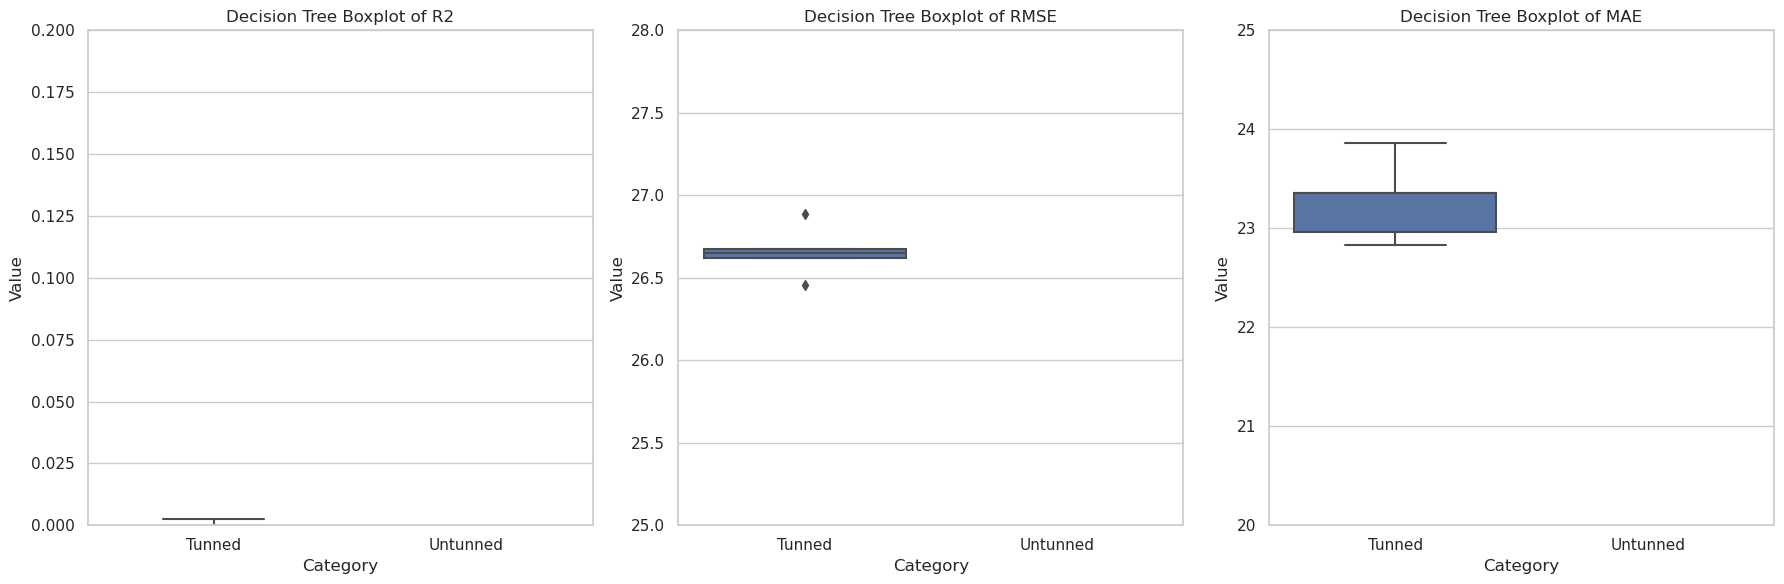

In [34]:
visualize(dt_results, "Decision Tree")

### Xgboost

In [35]:
untunned_xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.001)
untunned_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
kfold = KFold(n_splits=5)
untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_results_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*-1)
untunned_mae_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_absolute_error')*-1

In [37]:
untunned_pred = untunned_xgb_model.predict(X_test)

In [38]:
untunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, untunned_pred))
print("RMSE : % f" %(untunned_xgb_rmse))

RMSE :  27.287323


In [39]:
untunned_xgb_mae = mean_absolute_error(y_test, untunned_pred)
print('mean absolute score:', untunned_xgb_mae)

mean absolute score: 23.794327160749276


In [40]:
untunned_xgb_r2 = r2_score(y_test, untunned_pred)
print('r2 score:',untunned_xgb_r2)

r2 score: 0.019712910260079375


In [41]:
# Randomized Search hyperparameter
xgb_reg = XGBRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=50, scoring='r2', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
                                        'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [42]:
k_folds = KFold(n_splits = 5)
xgb_mae = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
xgb_r2 = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [43]:
best_params_xgb = random_search_xgb.best_params_
print("Best parameters found: ", best_params_xgb)

best_model_xgb = random_search_xgb.best_estimator_
tunned_pred = best_model_xgb.predict(X_test)

Best parameters found:  {'subsample': 0.8, 'reg_lambda': 0.3, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [44]:
tunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, tunned_pred))
print("RMSE : % f" %(tunned_xgb_rmse))
tunned_xgb_mae = mean_absolute_error(y_test, tunned_pred)
print('mean absolute score:', tunned_xgb_mae)
tunned_xgb_r2 = r2_score(y_test, tunned_pred)
print('r2 score:',tunned_xgb_r2)

RMSE :  27.058183
mean absolute score: 23.27415323663656
r2 score: 0.03610737970737399


In [45]:
xgb_results = {
    "Tunned": {"r2": xgb_r2, "rmse": xgb_rmse, "mae": xgb_mae},
    "Untunned": {"r2": untunned_r2_results_xgb, "rmse": untunned_rmse_results_xgb, "mae": untunned_mae_results_xgb}
}
xgb_results

{'Tunned': {'r2': array([0.09221005, 0.04517767, 0.0655475 , 0.05311941, 0.08202705]),
  'rmse': array([26.26105878, 26.09046938, 26.2582535 , 26.49698655, 26.14715451]),
  'mae': array([22.75927899, 22.44635742, 22.53494443, 22.64685959, 22.36723794])},
 'Untunned': {'r2': array([0.02496797, 0.01905765, 0.02236296, 0.01642636, 0.0207567 ]),
  'rmse': array([27.21629414, 26.4449257 , 26.85814684, 27.00550602, 27.0056599 ]),
  'mae': array([23.7660956 , 22.85734831, 23.38884178, 23.45160627, 23.32131874])}}

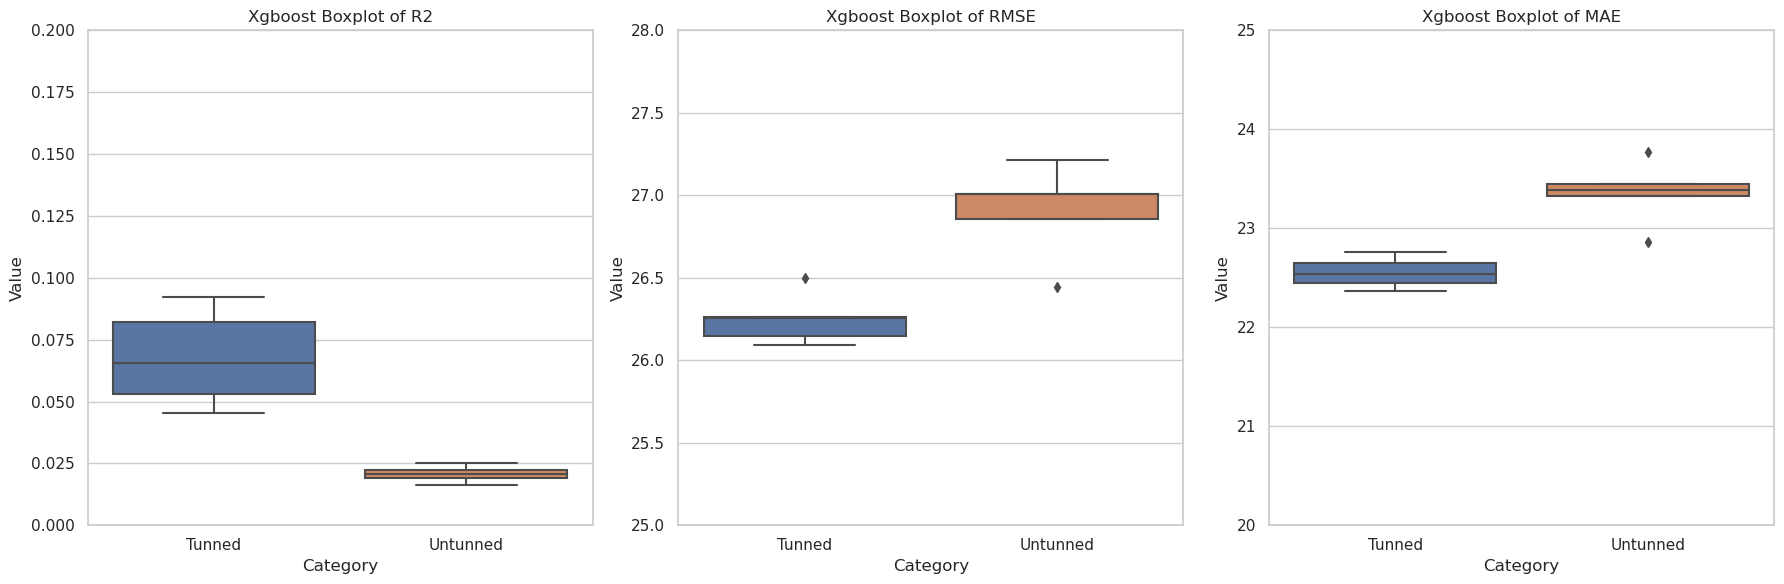

In [46]:
visualize(xgb_results, "Xgboost")

### Gradient Boost

In [47]:
 #Instantiate Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
gbr = GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=0.01,
                                n_estimators=1000,
                                max_depth = 6,
                                random_state = 42,
                                max_features = 5)

# Fit to training set
gbr.fit(X_train, y_train)

# Predict on test set
y_pred = gbr.predict(X_test)

# test set RMSE
untunned_test_rmse_gb = mean_squared_error(y_test, y_pred) ** (1 / 2)
untunned_test_r2_gb = r2_score(y_test, y_pred)
untunned_test_mae_gb = mean_absolute_error(y_test, y_pred)
# Print rmse
print('Root mean Square error: {:.2f}'.format(untunned_test_rmse_gb))
print('Mean Absolute error: {:.2f}'.format(untunned_test_mae_gb))
print('r2 score: {:.2f}'.format(untunned_test_r2_gb))

Root mean Square error: 27.25
Mean Absolute error: 23.41
r2 score: 0.02


In [48]:
k_folds = KFold(n_splits = 5)
untunned_gb_mae = cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
untunned_gb_r2 = cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "r2")
untunned_gb_rmse = np.sqrt(cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [49]:
param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 2),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5)
}

random_search_gbr = RandomizedSearchCV(
    estimator= GradientBoostingRegressor(),
    scoring=scoring,
    refit="r2",
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Number of folds in cross-validation
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_gbr.fit(X_train, y_train)

# Extract the best hyperparameters
best_params_gbr = random_search_gbr.best_params_
print("Best Hyperparameters: ", best_params_gbr)

# Extract cross-validation results
cv_results_gbr = pd.DataFrame(random_search_gbr.cv_results_)


Best Hyperparameters:  {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_depth': 3, 'learning_rate': 0.042222222222222223}


In [50]:
k_folds = KFold(n_splits = 5)
tunned_mae_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
tunned_r2_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
tunned_rmse_gb = np.sqrt(cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [51]:
gbr_r2 = cv_results_gbr['mean_test_r2'] *-1
mean_gbr_r2 = gbr_r2.mean()
gbr_mae = cv_results_gbr['mean_test_neg_mean_absolute_error'] * -1
mean_gbr_mae = gbr_mae.mean()
gbr_rmse = np.sqrt(cv_results_gbr['mean_test_neg_mean_squared_error'] * -1)
mean_gbr_rmse = gbr_rmse.mean()

In [52]:
gb_results = {
    "Tunned": {"r2": tunned_r2_gb, "rmse": tunned_rmse_gb, "mae": tunned_mae_gb},
    "Untunned": {"r2": untunned_gb_r2, "rmse": untunned_gb_rmse, "mae": untunned_gb_mae}
}
gb_results

{'Tunned': {'r2': array([0.0940609 , 0.04710846, 0.05282399, 0.06402926, 0.08635519]),
  'rmse': array([26.22951484, 26.0319387 , 26.4869976 , 26.43604886, 26.16353225]),
  'mae': array([22.6796396 , 22.33494916, 22.61581036, 22.51748428, 22.43849962])},
 'Untunned': {'r2': array([0.08958189, 0.041399  , 0.04925469, 0.04078452, 0.07337072]),
  'rmse': array([26.29904581, 26.14204437, 26.48617934, 26.66901451, 26.27014678]),
  'mae': array([22.70554267, 22.32684408, 22.62399411, 22.67274332, 22.33993808])}}

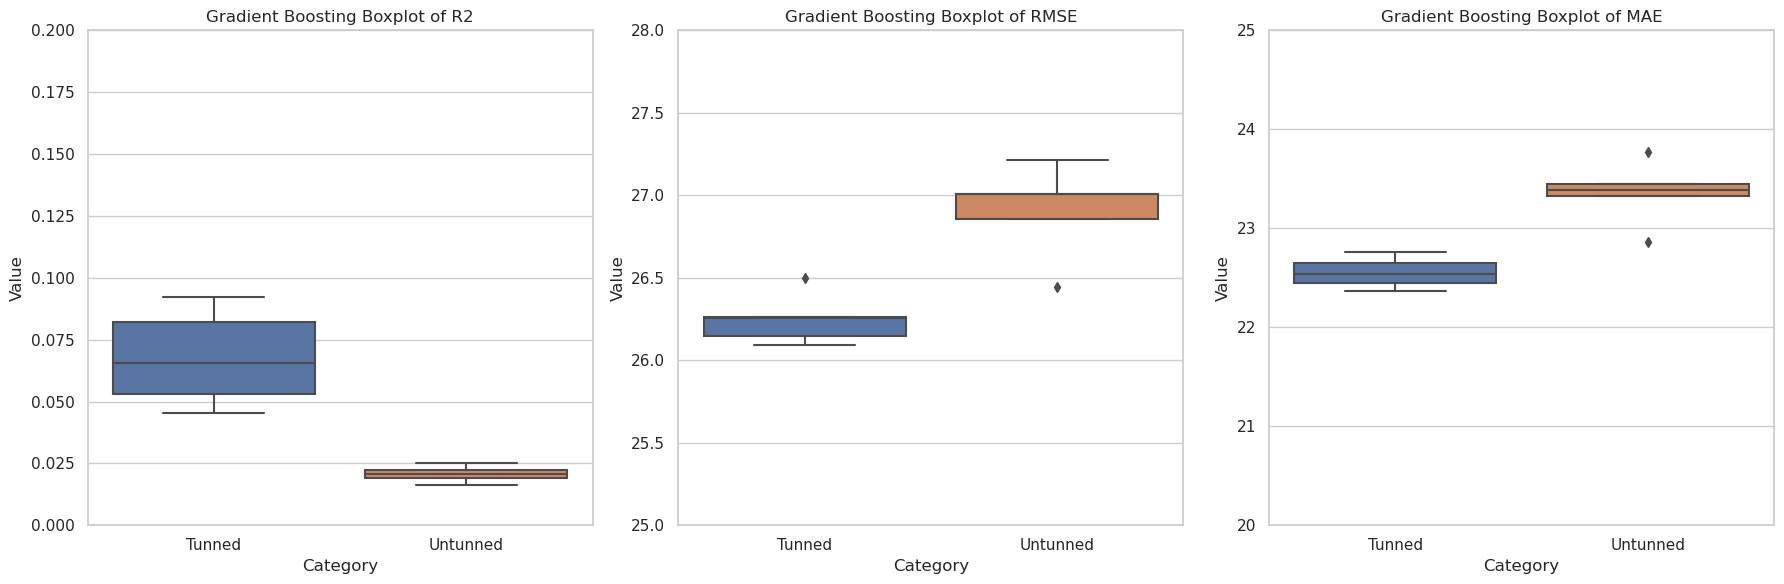

In [53]:
visualize(xgb_results, "Gradient Boosting")

### ANN

In [54]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled =  scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [55]:
# Create the model with increased max_iter
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}
untunned_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
scores = cross_validate(untunned_mlp, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)


In [56]:
print("RMSE:", -np.mean(scores['test_rmse']))
print("MAE:", -np.mean(scores['test_mae']))
print("R²:", np.mean(scores['test_r2']))

RMSE: 47.78318564739997
MAE: 23.880567514590393
R²: -3.1640689423023174


In [57]:
untunned_r2_mlp = np.mean(scores['test_r2'])
untunned_rmse_mlp = -np.mean(scores['test_rmse'])
untunned_mae_mlp = -np.mean(scores['test_mae'])


In [58]:
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (20,), (10, 10), (20, 10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    # 'alpha': [0.0001, 0.001, 0.01],
    # 'batch_size': [10, 20, 40],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],  # Added learning rate initialization
}

In [59]:
# Create the model with increased max_iter
mlp = MLPRegressor(max_iter=2000)

In [60]:
# Perform Grid Search with threading backend
with parallel_backend('threading'):
    grid = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=5, scoring='r2', return_train_score=True)
    grid_result = grid.fit(X_train_scaled, y_train)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_params_ann = grid_result.best_params_

KeyboardInterrupt: 

In [61]:
# # Evaluate the best model on the test set
# best_model = grid_result.best_estimator_
# y_pred = best_model.predict(X_test_scaled)
# mse_ann = mean_squared_error(y_test, y_pred)
# mae_ann = mean_absolute_error(y_test, y_pred)
# r2_ann = r2_score(y_test, y_pred)
# rmse_ann = np.sqrt(mse_ann)
# print(f'Test RMSE: {rmse_ann}')
# print(f'Test MAE: {mae_ann}')
# print(f'Test R2: {r2_ann}')

NameError: name 'grid_result' is not defined

In [ ]:
# k_folds = KFold(n_splits = 5)
# tunned_mae_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
# tunned_r2_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "r2")
# tunned_rmse_ann = np.sqrt(cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [ ]:
# ann_results = {
#     "Tunned": {"r2": tunned_r2_ann, "rmse": tunned_rmse_ann, "mae": tunned_mae_ann},
#     "Untunned": {"r2": scores['test_r2'], "rmse": -scores['test_rmse'], "mae": -scores['test_mae']}
# }
# ann_results

In [ ]:
# visualize(ann_results, "ANN")

## Results before finetuning

In [62]:
#before fine tuning
untuned_results ={"Scoring": [],
               "random forest":[],
               "decision tree":[],
                "Xgboost": [],
                "gradient boost": [],
                "ann": []
              }
untuned_results["Scoring"].append("r2_score")
untuned_results["random forest"].append(average_untuned_r2_rf)
untuned_results["decision tree"].append(average_untuned_r2_dt)
untuned_results["Xgboost"].append(untunned_xgb_r2)
untuned_results["gradient boost"].append(untunned_test_r2_gb)
untuned_results["ann"].append(untunned_r2_mlp)

untuned_results["Scoring"].append("MAE")
untuned_results["random forest"].append(average_untuned_mae_rf)
untuned_results["decision tree"].append(average_untuned_mae_dt)
untuned_results["Xgboost"].append(untunned_xgb_mae)
untuned_results["gradient boost"].append(untunned_test_mae_gb)
untuned_results["ann"].append(untunned_mae_mlp)

untuned_results["Scoring"].append("RMSE")
untuned_results["random forest"].append(average_untuned_rmse_rf)
untuned_results["decision tree"].append(average_untuned_rmse_dt)
untuned_results["Xgboost"].append(untunned_xgb_rmse)
untuned_results["gradient boost"].append(untunned_test_rmse_gb)
untuned_results["ann"].append(untunned_rmse_mlp)


In [63]:
untuned_results = pd.DataFrame(untuned_results)
untuned_results

,Scoring,random forest,decision tree,Xgboost,gradient boost,ann
0,r2_score,0.038715,-0.839695,0.019713,0.022478,-3.164069
1,MAE,22.772904,29.928192,23.794327,23.406486,23.880568
2,RMSE,26.655257,36.864345,27.287323,27.248812,47.783186


## Overall finetuned Results

In [64]:
results = {"Scoring": [],
           "random forest":[],
           "decision tree":[],
           "Xgboost":[],
           "Gradient Boost":[],
#           "ANN":[]
          }
results["Scoring"].append("r2_score")
results["random forest"].append(mean_rf_r2)
results["decision tree"].append(average_r2_dt)
results["Xgboost"].append(tunned_xgb_r2)
results["Gradient Boost"].append(mean_gbr_r2)
# results["ANN"].append(r2_ann)

In [65]:
results["Scoring"].append("MAE")
results["random forest"].append(mean_rf_mae)
results["decision tree"].append(average_mae_dt)
results["Xgboost"].append(tunned_xgb_mae)
results["Gradient Boost"].append(mean_gbr_mae)
# results["ANN"].append(mae_ann)

In [66]:
results["Scoring"].append("RMSE")
results["random forest"].append(mean_rf_rmse)
results["decision tree"].append(average_rmse_dt)
results["Xgboost"].append(tunned_xgb_rmse)
results["Gradient Boost"].append(mean_gbr_rmse)
# results["ANN"].append(rmse_ann)

In [67]:
df_results = pd.DataFrame(results)
df_results

,Scoring,random forest,decision tree,Xgboost,Gradient Boost
0,r2_score,-0.052611,-0.029429,0.036107,0.033061
1,MAE,22.579063,23.273391,23.274153,23.180586
2,RMSE,26.364507,26.657603,27.058183,27.502510


## Best Parameters

In [ ]:
best_params = {
    "ANN":best_params_ann,
    "Random Forest":best_params_rf,
    "Decision Tree":best_params_dt,
    "XgBoost":best_params_xgb,
    "Gradient Boost": best_params_gbr,

}
best_params